# Text Classification 2: Natural Language Toolkit
------------------

## Table of Contents

__[1. Where We Left Off](#first-bullet)__

__[2. NLTK: Stop Words, Stemming & Lemmatization](#second-bullet)__

__[3. Hyperparameter Tunning With GridSearchCV](#third-bullet)__

__[4. Conclusion](#fourth-bullet)__


---------

## Where We Left Off <a class="anchor" id="first-bullet"></a>
-----------

In the last [blogpost](http://michael-harmon.com/blog/NLP1.html) we covered text classification using <a href="http://scikit-learn.org/">Scikit-learn</a> and [Imbalance-Learn](https://imbalanced-learn.readthedocs.io/en/stable/) on summaries of papers from [arxiv](https://arxiv.org). We went over the basics of term frequency-inverse document frequency, Naive Bayes and Support Vector Machines. We additionally discussed techniques for handling imbalanced data both the data level and the algorithm level. In this post we'll pick up where we left off and cover uses of the [Natural Language Toolkit (NLTK)](https://www.nltk.org/) and hyperparameter tunning. Specifically we will discuss stop words, stemming and lemmatization on the previously mentioned classifiers.

First thing we need to do is connect to our [MongoDB](https://www.mongodb.com/) database:

In [3]:
import pymongo
conn = pymongo.MongoClient('mongodb://mongodb:27017')
db   = conn.db_arxiv

Then get the data in the Pandas dataframe format again:

In [4]:
import pandas as pd

# projection for subselecting only `text` and `category` fields
project = {"_id":0,"text":1,"category":1}

# get the training set
train_df = pd.DataFrame(db.train_cs_papers.find({},project))

# get the testing set
test_df = pd.DataFrame(db.test_cs_papers.find({},project))

Let's relabel our target variable. We create the mapping between the target and text category as well as the `y_test` vector for one vs rest classification to make the ROC and precission/recall curve:

In [5]:
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np

labeler            = LabelEncoder()
train_df["target"] = labeler.fit_transform(train_df["category"])
test_df["target"]  = labeler.transform(test_df["category"])

# get the number of classes
n_classes = len(train_df["target"].unique())

# classes = [0,1,2,3]
classes   = np.sort(train_df["target"].unique())

# relabel the test set
y_test = label_binarize(test_df["target"], 
                        classes=classes)

mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
print(mapping)

{'ai': 0, 'cv': 1, 'ml': 2, 'ro': 3}


Let's remind ourselves of where we left off with the modeling by looking at the last Naive Bayes and Support Vector Classifier we used:

In [6]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer)

from sklearn.naive_bayes     import MultinomialNB
from sklearn.metrics         import balanced_accuracy_score

from imblearn.pipeline       import Pipeline 
from imblearn.over_sampling  import RandomOverSampler

nb_pipe  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

We use our model [evaluator function](https://github.com/mdh266/DocumentClassificationNLP/blob/master/evaluator.py) and [partial](https://docs.python.org/2/library/functools.html) so that we only have to feed in the different pipeline each time we want to call it:

In [7]:
from utils.evaluator import evaluate_model
from functools import partial

evaluate_pipeline = partial(evaluate_model,
                            train_df,
                            test_df,
                            mapping)

Now we can evaluate the Naive Bayes model pipeline,

In [8]:
evaluate_pipeline(nb_pipe)

              precision    recall  f1-score   support

          ai       0.95      0.83      0.89       500
          cv       0.92      0.92      0.92       500
          ml       0.81      0.91      0.86       500
          ro       0.81      0.80      0.81        75

    accuracy                           0.88      1575
   macro avg       0.87      0.87      0.87      1575
weighted avg       0.89      0.88      0.88      1575


balanced_accuracy 0.8654999999999999


And the ROC and precision recall curves:

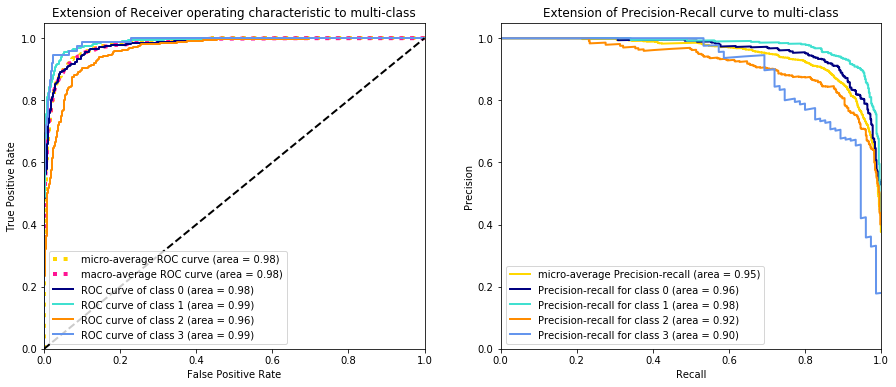

In [9]:
from utils.Plot_ROC_PR_Curve import plot_roc_pr

y_pred = nb_pipe.predict_proba(test_df["text"])

plot_roc_pr(y_pred = y_pred, y_test = y_test)

Now let's move on to the weighted Support Vector Classifier we left off with:

In [8]:
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('model',   LinearSVC(class_weight='balanced',
                                           random_state=50))])

evaluate_pipeline(svm_pipe)

              precision    recall  f1-score   support

          ai       0.92      0.90      0.91       500
          cv       0.92      0.92      0.92       500
          ml       0.85      0.89      0.87       500
          ro       0.92      0.80      0.86        75

    accuracy                           0.90      1575
   macro avg       0.90      0.88      0.89      1575
weighted avg       0.90      0.90      0.90      1575


balanced_accuracy 0.877


The ROC and precision/recall curves for this model are,

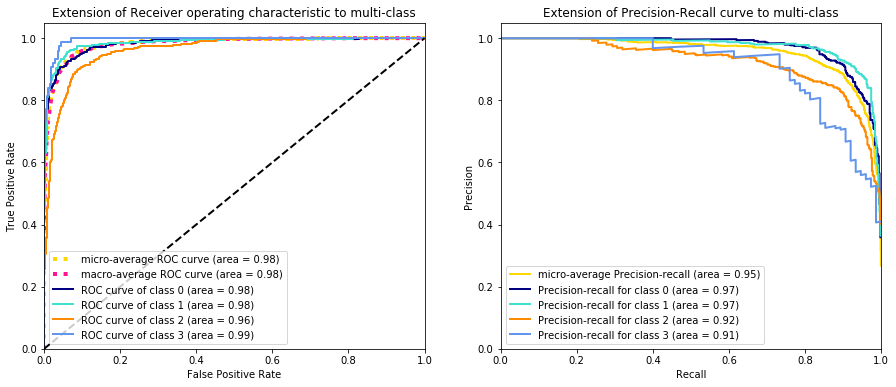

In [9]:
y_pred = svm_pipe.decision_function(test_df["text"])

plot_roc_pr(y_pred = y_pred, y_test = y_test)

Now lets improve our models using the Natural Language Toolkit!

## NLTK: Stop Words, Stemming, & Lemmatization <a class="anchor" id="second-bullet"></a>
------------

### Stop Words
We can look to improve our model by removing <a href="https://en.wikipedia.org/wiki/Stop_words">stop words</a> which are common words in the english language and do not add any information into the text. These includes words such as, "the", "at", "is", etc.  Let's look at an example using the Natural Language Toolkit ([NLTK](https://www.nltk.org/#)).  First we get an example document that we can show the effect of what removing stop words from a document does.

In [11]:
# example document
doc_lines = train_df["text"][242].split(".|\n")
print("\n".join(doc_lines))

We address the problem of the development of representations and their
relationship to the environment. We study a software agent which develops in a
network a representation of its simple environment which captures and
integrates the relationships between agent and environment through a closure
mechanism. The inclusion of a variable behavior modifier allows better
representation development. This can be confirmed with an internal description
of the closure mechanism, and with an external description of the properties of
the representation network.


We import the nltk package and download the data required for stopwords.

In [12]:
import nltk
# uncomment the below to download the data if you need to
# nltk.download()
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

Now we collect the stop words as a set. We have to do things in a funky way so that the formatting is the same as above.  `doc_lines` is a list where each entry in the line in the document. In order to preserve this we have to tokenize each line, filter it, then use join to make it a string again. We do this independently for each line in the list and then join the list of strings back and insert a "\n" between the filtered lines to make the format match the previous document.

In [13]:
# collect the stopwords
stop_words    = set(stopwords.words('english')) 

# tokenize each line in the list of lines 
lines_tokens  = [word_tokenize(line) for line in doc_lines]

# remove stop words from each line/list
filter_lines  = [" ".join([token.lower() for token in tokens if token not in stop_words])
                 for tokens in lines_tokens]

print("\n".join(filter_lines))

we address problem development representations relationship environment . we study software agent develops network representation simple environment captures integrates relationships agent environment closure mechanism . the inclusion variable behavior modifier allows better representation development . this confirmed internal description closure mechanism , external description properties representation network .


As mentioned the CountVectorizer will be take care of the punctuation. CountVectorizer also has the ability to remove stop words by declaring to remove them in the constructor.  We could do this, but instead lets create our own tokenizer that removes stop words so that we can add stopwords outside of those predefined by Scikit-Learn if needed:

In [14]:
class StopWordTokenizer(object):
    """
    StopWordsTokenizer tokenizes words and removes stopwords that are 
    passed in through the the constructor.
    """
    def __init__(self, stop_words):
        self.stop_words = stop_words
        
    def __call__(self, articles):
        return [token for token in word_tokenize(articles) if token not in self.stop_words]

Now let's see how using stop words effects our Naive Bayes model performance:

In [15]:
nb_pipe  = Pipeline([('vect',    CountVectorizer(tokenizer=StopWordTokenizer(stop_words))),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

evaluate_pipeline(nb_pipe)

              precision    recall  f1-score   support

          ai       0.96      0.88      0.92       500
          cv       0.91      0.91      0.91       500
          ml       0.83      0.89      0.86       500
          ro       0.84      0.92      0.88        75

    accuracy                           0.89      1575
   macro avg       0.89      0.90      0.89      1575
weighted avg       0.90      0.89      0.89      1575


balanced_accuracy 0.8995


A slight improvement in recall, but at the expense of precision.  Let's try stop words with the Support Vector Classifier.

In [19]:
svm_pipe  = Pipeline([('vect',    CountVectorizer(tokenizer=StopWordTokenizer(stop_words))),
                      ('tfidf',   TfidfTransformer()),
                      ('model',   LinearSVC(class_weight='balanced',
                                            random_state=50))])

evaluate_pipeline(svm_pipe)

              precision    recall  f1-score   support

          ai       0.92      0.91      0.91       500
          cv       0.92      0.92      0.92       500
          ml       0.86      0.88      0.87       500
          ro       0.94      0.80      0.86        75

    accuracy                           0.90      1575
   macro avg       0.91      0.88      0.89      1575
weighted avg       0.90      0.90      0.90      1575


balanced_accuracy 0.8780000000000001


Not too much of an improvement.

### Stemming & Lemmatization

Now let's try using [Stemming and Lemmaitization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) to improve the model performance. Stemming and Lemmatization are two processes that reduce words down to a simplier form, i.e. their "root".  This reduces the variations in words and hence the dimensionality in our model. You can see some of my work with Stemming [here](http://michael-harmon.com/blog/SentimentAnalysisP2.html). Stemming is rather rudimentary and only looks at and acts on individual words, reducing them to the simplier form.  Lemmatization on the otherhand depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. I should note that stemming is known to [improve recall and degrade precision](https://en.wikipedia.org/wiki/Lemmatisation).

We use the [Snowball Stemmer](https://www.nltk.org/_modules/nltk/stem/snowball.html) and [WordNetLemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) from the NLTK and show what it does to the previous example document:

In [20]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

lemmer  = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

stemmed_lines     = [" ".join([stemmer.stem(token).lower() 
                              for token in tokens if token not in stop_words])
                              for tokens in lines_tokens]

lemmatized_lines  = [" ".join([lemmer.lemmatize(token).lower() 
                              for token in tokens if token not in stop_words])
                              for tokens in lines_tokens]
print("StopWords:\n")
print("\n".join(filter_lines))
print()
print("StopWords + Stemming:\n")
print("\n".join(stemmed_lines))
print()
print("StopWords + Lemmatization:\n")
print("\n".join(lemmatized_lines))

StopWords:

we address problem development representations relationship environment . we study software agent develops network representation simple environment captures integrates relationships agent environment closure mechanism . the inclusion variable behavior modifier allows better representation development . this confirmed internal description closure mechanism , external description properties representation network .

StopWords + Stemming:

we address problem develop represent relationship environ . we studi softwar agent develop network represent simpl environ captur integr relationship agent environ closur mechan . the inclus variabl behavior modifi allow better represent develop . this confirm intern descript closur mechan , extern descript properti represent network .

StopWords + Lemmatization:

we address problem development representation relationship environment . we study software agent develops network representation simple environment capture integrates relationship

We can see that stemming is very aggressive in reducing words to their root form while lemmatization does not blindly change words to their roots.  It turns out as only "captures" and "properties" were changed.  Let's now use both in our model by modifying the `StopWordTokenizer` from before:

In [21]:
class StemTokenizer(object):
    """
    StemTokenizer tokenizes words, removes stopwords and stems words
    in each document.
    """
    def __init__(self, stop_words):
        self.stop_words = stop_words
        self.stemmer    = SnowballStemmer(language='english')
        
    def __call__(self, articles):
        return [self.stemmer.stem(token) 
                for token in word_tokenize(articles) if token not in self.stop_words]


class LemmaTokenizer(object):
    """
    LemmaTokenizer tokenizes words, removes stopwords and lemmatizes words
    in each document.
    """
    def __init__(self, stop_words):
        self.stop_words = stop_words
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, articles):
        return [self.lemmatizer.lemmatize(token) 
                for token in word_tokenize(articles) if token not in self.stop_words]


Note that we **first remove stop words and then stem/lemmatize words.** Now lets see how these effect the model performance. Instead of iteratively going through them and seeing which one performs the best, well just perform a grid search and take the best model.  Well go over the details of the GridSearchCV more in the next section so lets just jump to the results:

In [28]:
from sklearn.model_selection import GridSearchCV

params = {'vect__tokenizer': (StopWordTokenizer(stop_words=stop_words),
                              StemTokenizer(stop_words=stop_words),
                              LemmaTokenizer(stop_words=stop_words))}

# 5 fold cross validation
nb_grid_search = GridSearchCV(estimator   = nb_pipe, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)
# fit the models
nb_gs_model = nb_grid_search.fit(train_df["text"], 
                                train_df["target"])

We can then see which pre-processing routine performed best:

In [34]:
print(nb_gs_model.best_estimator_.steps[0][1])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.LemmaTokenizer object at 0x1a230d5e50>,
                vocabulary=None)


The best model in the grid search used the Lemmatizer. Now let's get the pefromance on the test set:

In [37]:
nb_pipe  = Pipeline([('vect',    CountVectorizer(tokenizer=LemmaTokenizer(stop_words))),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

evaluate_pipeline(nb_pipe)

              precision    recall  f1-score   support

          ai       0.96      0.87      0.91       500
          cv       0.90      0.91      0.91       500
          ml       0.83      0.89      0.86       500
          ro       0.83      0.91      0.87        75

    accuracy                           0.89      1575
   macro avg       0.88      0.89      0.88      1575
weighted avg       0.89      0.89      0.89      1575


balanced_accuracy 0.8926666666666667


A slight improvement in the balanced accuracy overall, but not too much.  Now let's try the same thing for the Support Vector Machine:

In [38]:
# 5 fold cross validation
svm_grid_search = GridSearchCV(estimator  = svm_pipe, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)

# fit the models
svm_gs_model = svm_grid_search.fit(train_df["text"], 
                                   train_df["target"])

And we can get which pre-processing routine performed best again:

In [39]:
print(svm_gs_model.best_estimator_.steps[0][1])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.StemTokenizer object at 0x1a1d574cd0>,
                vocabulary=None)


Interestingly the SVM which uses the stemming tokenizer!  Let's see how it does on the test set:

In [42]:
svm_pipe  = Pipeline([('vect',    CountVectorizer(tokenizer=StemTokenizer(stop_words))),
                      ('tfidf',   TfidfTransformer()),
                      ('model',   LinearSVC(class_weight='balanced',
                                            random_state=50))])

evaluate_pipeline(svm_pipe)

              precision    recall  f1-score   support

          ai       0.91      0.91      0.91       500
          cv       0.92      0.92      0.92       500
          ml       0.86      0.88      0.87       500
          ro       0.91      0.83      0.87        75

    accuracy                           0.90      1575
   macro avg       0.90      0.88      0.89      1575
weighted avg       0.90      0.90      0.90      1575


balanced_accuracy 0.8821666666666667


Overall lemmatization improves Naive Bayes model while stemming improves the Support Vector Machine model.  Next we'll look at hyperparameter tunning to see if we can improve the model performance.

## HyperParameter Tuning With GridSearchCV <a class="anchor" id="third-bullet"></a>
----------------

Not only do pipelines allow us to swap out our model much easier, (say replace our Support Vector Classifier with a another Logistic Regression), but they also allow us to assemble several steps that can be cross-validated together while choosing different parameters. 

The hyperparameters we want to look at:

    - min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than this #
    
    - smooth_idf : Smooth idf weights by adding one to document frequencies
    
    - alpha : Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
    

To try different values of the hyperparametrs, pipelines enable setting parameters of the various steps using the pipeline stage name and the parameter name separated by a ‘__’.  

In [68]:
nb_params = {'vect__min_df'     : (1,5),
             'tfidf__smooth_idf': (True,False),
             'model__alpha'     : (1, 1e-1, 1e-2, 0)}

Notice how when we wish to change the model parameter `alpha` (which is a smoothing regularizer) by including on "model" and not the `model` object. We can perform the grid search with 5-fold cross validation in parallel by setting `cv = 5` and `n_jobs=-1`.  We use our scoring metric as `balanced_accuracy` to account for the imbalanced classes when doing the grid search.  This is another the way we tune our algorithm for handling imbalanced data.

In [69]:
# 5 fold cross validation
nb_grid_search = GridSearchCV(estimator  = nb_pipe, 
                              param_grid = nb_params, 
                              scoring    = "balanced_accuracy",
                              cv         = 5,
                              n_jobs     =-1)

We can then fit the data to perform the actual grid search,

In [70]:
nb_gs_model = nb_grid_search.fit(train_df["text"], 
                                 train_df["target"])

Our model `gs_model` uses the paremeters which had the best cross-validated score. We can see a full description of the best model,

In [71]:
print(nb_gs_model.best_estimator_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x1196f3910>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('sampler',
                 RandomOverSampler(random_state=42,
                     

As well as it's performance:

              precision    recall  f1-score   support

          ai       0.96      0.87      0.91       500
          cv       0.90      0.91      0.91       500
          ml       0.83      0.89      0.86       500
          ro       0.83      0.91      0.87        75

    accuracy                           0.89      1575
   macro avg       0.88      0.89      0.88      1575
weighted avg       0.89      0.89      0.89      1575


balanced_accuracy 0.8926666666666667


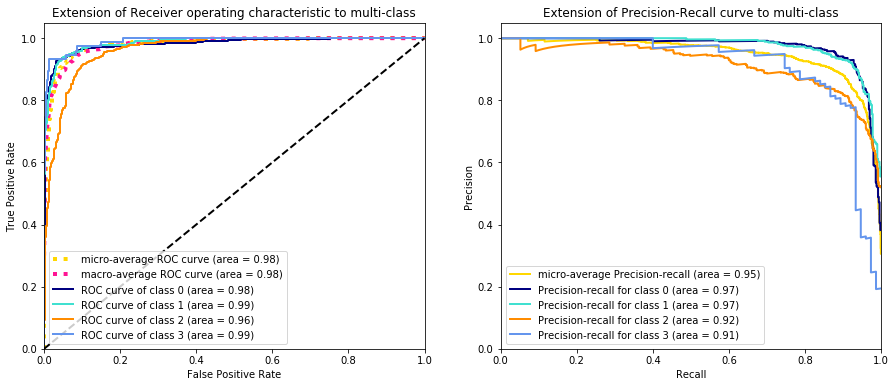

In [72]:
from sklearn.metrics import (classification_report,
                             balanced_accuracy_score)

pred   = nb_gs_model.predict(test_df["text"])
y_pred = nb_gs_model.predict_proba(test_df["text"])

print(classification_report(test_df["target"],
                            pred, 
                            target_names=mapping))

print("\nbalanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                     pred))

plot_roc_pr(y_pred = y_pred, y_test = y_test)

We can see that we werent able to improve the model peformance with a gridsearch, but we still have a pretty decent model nonetheless. Let's try the same thing on the support vector machine:

In [62]:
svm_params = {'vect__min_df'     : (1,5),
             'tfidf__smooth_idf': (True,False),
             'model__C'         : (2, 1, 0.5, 0.1)}

svm_grid_search = GridSearchCV(estimator = svm_pipe, 
                              param_grid = svm_params, 
                              scoring    = "balanced_accuracy",
                              cv         = 5,
                              n_jobs     =-1)

svm_gs_model = svm_grid_search.fit(train_df["text"], 
                                   train_df["target"])

print(svm_gs_model.best_estimator_)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemTokenizer object at 0x1a28188a50>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 LinearSVC(C=0.1, class_weight='balanced', dual=True,
     

We can persist the best Support Vector Classifier model to disk using [joblib](https://scikit-learn.org/stable/modules/model_persistence.html) as it can be more efficient than pickle:

In [2]:
import joblib 
joblib.dump(svm_gs_model.best_estimator_, '../models/weighted_svm.joblib') 

We can then load the model again and use it to get the model performance on the test set:

In [4]:
model  = joblib.load('../models/weighted_svm.joblib') 
pred   = model.predict(test_df["text"])
y_pred = model.decision_function(test_df["text"])

print(classification_report(test_df["target"],
                            pred, 
                            target_names=mapping))

print("\nbalanced_accuracy", balanced_accuracy_score(test_df["target"], 
                                                     pred))

plot_roc_pr(y_pred = y_pred, y_test = y_test)

Overall both models are pretty good and have comparable balanced accuracy scores, but I like the Support Vector Machine the best!

## Conclusion <a class="anchor" id="fourth-bullet"></a>

In this blogpost we picked up from the [last one](http://michael-harmon.com/blog/NLP1.html) and went over using the Natural Language Toolkit to improve the performance of our text classification models. Specifically, we went over how to remove stopwords, stemming and lemmitization. We applied each of these to our Naive Bayes and Support Vector Machine models and performed as grid search to find the optimal parameters to use for our models. 